In [6]:
import os
os.chdir("../..")
os.getcwd() 

'/Users/arthurphan/Desktop/MAPIE'

In [7]:
import warnings

import datetime
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.subsample import BlockBootstrap
from mapie.time_series_regression import MapieTimeSeriesRegressor

%reload_ext autoreload
%autoreload 2
warnings.simplefilter("ignore")

In [8]:
os.chdir("notebooks/regression")
os.getcwd()

'/Users/arthurphan/Desktop/MAPIE/notebooks/regression'

In [9]:
#########################################################
# Global random forests parameters
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = 6

model = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=1)

In [10]:
data = pd.read_csv("Prices_2016_2019_extract.csv")

In [11]:
data.head()

,Date,Spot,hour,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,...,lag_168_15,lag_168_16,lag_168_17,lag_168_18,lag_168_19,lag_168_20,lag_168_21,lag_168_22,lag_168_23,conso
0,2016-01-08 00:00:00,24.36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,62700.0
1,2016-01-08 01:00:00,19.33,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,60700.0
2,2016-01-08 02:00:00,16.10,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,59200.0
3,2016-01-08 03:00:00,15.00,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,56400.0
4,2016-01-08 04:00:00,15.00,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,55300.0


In [12]:
data.shape

(34896, 59)

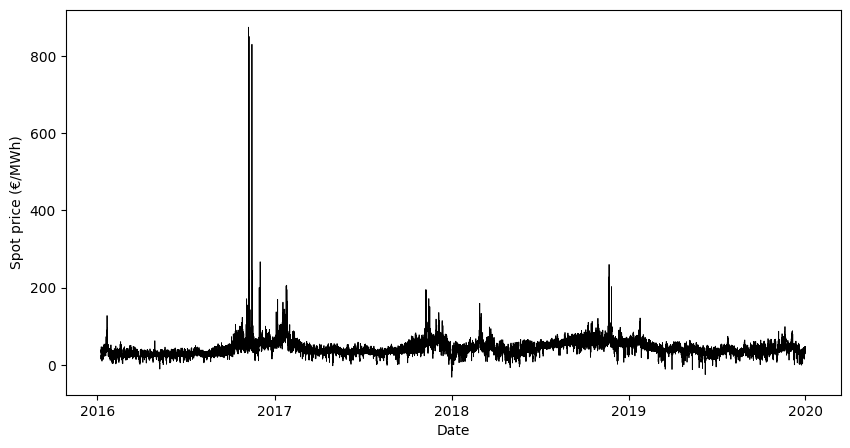

In [13]:
date_plot = pd.to_datetime(data.Date)

plt_1 = plt.figure(figsize=(10, 5))
plt.plot(date_plot, data.Spot, color='black', linewidth=0.6)
locs, labels = plt.xticks()
plt.xticks(locs[0:len(locs):2], labels=['2016','2017','2018','2019','2020'])
plt.xlabel('Date')
plt.ylabel('Spot price (\u20AC/MWh)')
plt.show()

In [14]:
limit = datetime.datetime(2019, 1, 1, tzinfo=datetime.timezone.utc)
id_train = data.index[pd.to_datetime(data['Date'], utc=True) < limit].tolist()
id_test = data.index[pd.to_datetime(data['Date'], utc=True) >= limit].tolist()

data_train = data.iloc[id_train,:]
data_test = data.iloc[id_test,:]

In [15]:
X_train = data_train.loc[:,['hour','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6'] + 
                       ['lag_24_%d'%i for i in range(24)] +
                       ['lag_168_%d'%i for i in range(24)] + ['conso']]
y_train = data_train.Spot

X_train_0 = X_train.loc[X_train.hour == 0]
y_train_0 = data_train.loc[data_train.hour == 0, 'Spot']

X_test = data_test.loc[:,['hour','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6'] + 
                       ['lag_24_%d'%i for i in range(24)] +
                       ['lag_168_%d'%i for i in range(24)] + ['conso']]

y_test = data_test.Spot

X_test_0 = X_test.loc[X_test.hour == 0]
y_test_0 = data_test.loc[data_test.hour == 0, 'Spot']

In [16]:
alpha = 0.1
gap = 1
tab_gamma = [0,
             0.000005,
             0.00005,
             0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
             0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]

mapie_aci = MapieTimeSeriesRegressor(
    model, method="aci", agg_function="mean", n_jobs=-1
)


In [22]:
import pickle

path_to_pickle_file = '/Users/arthurphan/Desktop/MAPIE/notebooks/regression/results/Spot_France_Hour_0_train_2019-01-01/ACP_0.04_RF.pkl'

try:
    with open(path_to_pickle_file, 'rb') as file:
        loaded_data = pickle.load(file)

except FileNotFoundError:
    print(f"The file {path_to_pickle_file} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
    
path_to_csv_files = '/Users/arthurphan/Desktop/MAPIE/notebooks/regression/results_csv/Spot_France_Hour_0_train_2019-01-01'

data_dict = {}

for filename in os.listdir(path_to_csv_files):
    if filename.endswith('.csv') and 'ACP' in filename:
        file_path = os.path.join(path_to_csv_files, filename)  
        df = pd.read_csv(file_path)  
        data_dict[filename] = df
        
bounds = data_dict["ACP_0.04_RF.pkl.csv"][["Y_inf","Y_sup"]]
y_pred_MZ = (bounds["Y_inf"]+bounds["Y_sup"])/2


In [23]:
from tqdm.autonotebook import tqdm
import numpy as np
all_x_train = [np.array(data_train.loc[data_train.hour == h]) for h in range(24)]

train_size = all_x_train[0].shape[0]
idx = np.array(range(train_size))
n_half = int(np.floor(train_size/2))

X_train_0 = X_train_0[:n_half]
y_train_0 = y_train_0[:n_half]

mapie_aci = mapie_aci.fit(X_train_0, y_train_0)
y_pred_aci_npfit, y_pis_aci_npfit = mapie_aci.predict(
    X_test_0, alpha=alpha, ensemble=True, optimize_beta=False
)

y_pred_aci_pfit = np.zeros(y_pred_aci_npfit.shape)
y_pis_aci_pfit = np.zeros(y_pis_aci_npfit.shape)
y_pred_aci_pfit[:gap], y_pis_aci_pfit[:gap, :, :] = mapie_aci.predict(
    X_test_0.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=False
)

results_dict = {}

#for gamma in tab_gamma:
for step in tqdm(range(1, len(X_test_0), gap)):

    mapie_aci.estimator_.single_estimator_.fit(X_test_0.iloc[(step - gap):step, :],
                                               y_test_0.iloc[(step - gap):step])

    mapie_aci.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )

    mapie_aci.adapt_conformal_inference(
        X_test_0.iloc[(step - gap):step, :],
        y_test_0.iloc[(step - gap):step],
        gamma = 0.04
    )
    (
        y_pred_aci_pfit[step:step + gap],
        y_pis_aci_pfit[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test_0.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    results_dict[f"ACP_0.04"] = y_pis_aci_pfit.copy()
    #results_dict[f"ACP_{gamma}"] = y_pis_aci_pfit.copy()

  0%|          | 0/364 [00:00<?, ?it/s]

In [26]:
results_dict[f"ACP_0.04"] 

array([[[43.39998634],
        [50.68138079]],

       [[40.35935726],
        [48.96536313]],

       [[43.60850369],
        [54.10868228]],

       [[50.25374583],
        [60.58196855]],

       [[54.06848877],
        [64.11206699]],

       [[36.95731765],
        [68.07140934]],

       [[27.79420083],
        [58.42059847]],

       [[32.04229215],
        [62.6252957 ]],

       [[31.3118286 ],
        [58.538132  ]],

       [[32.07586879],
        [58.51352074]],

       [[33.75586156],
        [67.18277682]],

       [[35.08413138],
        [66.28335259]],

       [[25.58483362],
        [56.16783717]],

       [[21.06546151],
        [54.49237676]],

       [[26.97075719],
        [58.1699784 ]],

       [[30.7533009 ],
        [61.33630445]],

       [[31.09657428],
        [59.86412265]],

       [[33.66978204],
        [61.6436727 ]],

       [[39.52168494],
        [65.6334927 ]],

       [[41.08805184],
        [65.84656616]],

       [[33.11768941],
        [77.73338

In [24]:
loaded_data["alpha_t"]

array([[0.1  , 0.104, 0.068, 0.072, 0.076, 0.04 , 0.044, 0.048, 0.052,
        0.056, 0.06 , 0.064, 0.068, 0.072, 0.076, 0.08 , 0.084, 0.088,
        0.092, 0.096, 0.1  , 0.104, 0.108, 0.112, 0.116, 0.12 , 0.124,
        0.128, 0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 ,
        0.164, 0.168, 0.172, 0.176, 0.18 , 0.184, 0.148, 0.152, 0.156,
        0.16 , 0.164, 0.168, 0.172, 0.176, 0.18 , 0.184, 0.188, 0.192,
        0.196, 0.2  , 0.204, 0.208, 0.212, 0.216, 0.22 , 0.224, 0.188,
        0.192, 0.196, 0.2  , 0.204, 0.208, 0.212, 0.176, 0.18 , 0.184,
        0.148, 0.152, 0.156, 0.16 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
        0.144, 0.148, 0.152, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136,
        0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172,
        0.176, 0.18 , 0.184, 0.188, 0.192, 0.156, 0.12 , 0.124, 0.128,
        0.132, 0.136, 0.14 , 0.144, 0.148, 0.112, 0.116, 0.12 , 0.124,
        0.128, 0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 ,
      

In [25]:
pd.DataFrame(results_dict["ACP_0.04"].reshape(-1, 2),columns=["Y_inf","Y_sup"])

,Y_inf,Y_sup
0,43.399986,50.681381
1,40.359357,48.965363
2,43.608504,54.108682
3,50.253746,60.581969
4,54.068489,64.112067
...,...,...
360,9.950592,43.350358
361,16.194515,49.541197
362,13.629289,46.682438
363,13.640961,46.559454
